In [2]:
import numpy as np
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from parse_filenames import parse_filenames
from scipy import stats
import pickle

In [3]:
path = Path.home() / 'Desktop' / 'disk2' / 'grand_average_lfps'

# 1) Parsing filenames of averaged LFPs

In [4]:
parsed_df = parse_filenames(path)
parsed_df.head()

,sessionID,area,condition,running,flashesAveragedOver,micronsElectrodeDepth,filename
0,794812542,VISpm,toWhite,True,2,992.0,sessionID_794812542_area_VISpm_condition_toWhi...
1,742951821,VISp,toWhite,True,2,NaN,sessionID_742951821_area_VISp_condition_toWhit...
2,771990200,VISp,toBlack,True,14,1039.0,sessionID_771990200_area_VISp_condition_toBlac...
3,797828357,VISp,toWhite,True,9,1046.0,sessionID_797828357_area_VISp_condition_toWhit...
4,797828357,VISp,toWhite,False,66,1046.0,sessionID_797828357_area_VISp_condition_toWhit...


In [5]:
# Deleting rows without 8 conditions

for sid in parsed_df.sessionID.unique():
    if len(parsed_df[parsed_df.sessionID==sid]) != 8:
        parsed_df = parsed_df.drop(parsed_df[parsed_df.sessionID==sid].index)

In [6]:
conditions = [('VISpm', 'toWhite', True), ('VISpm', 'toBlack', True), ('VISpm', 'toWhite', False), ('VISpm', 'toBlack', False),
             ('VISp', 'toWhite', True), ('VISp', 'toBlack', True), ('VISp', 'toWhite', False), ('VISp', 'toBlack', False)]

In [7]:
for condition in conditions:
    selected_df = parsed_df[(parsed_df.area==condition[0]) & (parsed_df.condition==condition[1]) & (parsed_df.running==condition[2])]
    print(condition, len(selected_df))

('VISpm', 'toWhite', True) 19
('VISpm', 'toBlack', True) 19
('VISpm', 'toWhite', False) 19
('VISpm', 'toBlack', False) 19
('VISp', 'toWhite', True) 19
('VISp', 'toBlack', True) 19
('VISp', 'toWhite', False) 19
('VISp', 'toBlack', False) 19


# 2) Calculating session averages (median + IQR)

In [8]:
def get_iqr(data):
    iqrs = []

    for t in range(data.shape[1]):
        iqr = stats.iqr(data[:,t])
        iqrs.append(iqr)
        
    return np.array(iqrs)

In [63]:
parsed_df['t'] = ''
parsed_df['median'] = ''
parsed_df['iqr'] = ''
parsed_df['filteredFlashesAveragedOver'] = ''

In [90]:
LOAD = True

In [91]:
if LOAD:
    # Load the df
    with open(Path.home() / 'Desktop' / 'disk2' / 'lfp_ts_parsed_df.pkl', 'rb') as f: parsed_df = pickle.load(f)
else:
    # For each condition
    # Select corresponding session-condition rows
    # Load (presentations X timepoints) LFP numpy array from provided filename
    # Filter out presentations that are flat: max amplitude == min amplitude
    # Calculate median and IQR and save them to a new column in corresponding session-condition row
    for condition in conditions:
        selected_df = parsed_df[(parsed_df.area==condition[0]) & (parsed_df.condition==condition[1]) & (parsed_df.running==condition[2])]
        for cols in selected_df.iterrows():
            t, lfp_arr = np.load(path / cols[1].filename, allow_pickle=True)
            # Filtering out flat LFP traces
            filtered_lfp_arr = []
            for i in range(lfp_arr.shape[0]):
                if lfp_arr[i].max() != lfp_arr[i].min():
                    filtered_lfp_arr.append(lfp_arr[i])
            filtered_lfp_arr = np.array(filtered_lfp_arr)
            print(cols[1].sessionID, lfp_arr.shape, filtered_lfp_arr.shape)
            # Saving time data, median time series and iqr (variability measure) time series for eahc condition-session entry
            parsed_df.at[cols[0], 't'] = t.data
            parsed_df.at[cols[0], 'median'] = np.median(filtered_lfp_arr, axis=0)
            parsed_df.at[cols[0], 'iqr'] = get_iqr(filtered_lfp_arr)
            parsed_df.at[cols[0], 'filteredFlashesAveragedOver'] = filtered_lfp_arr.shape[0]
    
    # Save the df
    with open(Path.home() / 'Desktop' / 'disk2' / 'lfp_ts_parsed_df.pkl', "wb") as f:
        pickle.dump(parsed_df, f)

In [92]:
parsed_df

,sessionID,area,condition,running,flashesAveragedOver,micronsElectrodeDepth,filename,t,median,iqr,filteredFlashesAveragedOver
1,742951821,VISp,toWhite,True,2,NaN,sessionID_742951821_area_VISp_condition_toWhit...,"[-1.0, -0.9991997866097626, -0.998399573219525...","[7.7025e-06, 1.5014999e-05, 2.3107503e-05, 2.8...","[4.94324995088391e-05, 4.81650022265967e-05, 5...",2
2,771990200,VISp,toBlack,True,14,1039.0,sessionID_771990200_area_VISp_condition_toBlac...,"[-1.0, -0.9991997866097626, -0.998399573219525...","[-1.66725e-05, -1.00425e-05, -1.51125e-05, -3....","[0.0001390349971188698, 0.00010905374620051589...",14
3,797828357,VISp,toWhite,True,9,1046.0,sessionID_797828357_area_VISp_condition_toWhit...,"[-1.0, -0.9991997866097626, -0.998399573219525...","[-2.964e-05, -5.4795e-05, -4.602e-05, -3.8805e...","[5.7914998251362704e-05, 8.287499986181501e-05...",9
4,797828357,VISp,toWhite,False,66,1046.0,sessionID_797828357_area_VISp_condition_toWhit...,"[-1.0, -0.9991997866097626, -0.998399573219525...","[-2.6325e-05, -3.3149998e-05, -4.55325e-05, -3...","[0.00019509749927237863, 0.0001991437466131174...",66
5,771990200,VISpm,toWhite,False,63,985.0,sessionID_771990200_area_VISpm_condition_toWhi...,"[-1.0, -0.9991997866097626, -0.998399573219525...","[-1.482e-05, -5.6549998e-06, -9.75e-06, -1.482...","[8.267999874078669e-05, 8.667750080348924e-05,...",63
...,...,...,...,...,...,...,...,...,...,...,...
150,715093703,VISp,toWhite,False,14,NaN,sessionID_715093703_area_VISp_condition_toWhit...,"[-1.0, -0.9991997866097626, -0.998399573219525...","[-7.215e-06, 1.21875e-05, -1.31625e-05, -1.17e...","[9.944999874278437e-05, 8.814000011625467e-05,...",14
151,771160300,VISp,toWhite,True,29,1135.0,sessionID_771160300_area_VISp_condition_toWhit...,"[-1.0, -0.9991997866097626, -0.998399573219525...","[1.872e-05, 1.7549999e-05, 1.3455e-05, 2.145e-...","[5.5964999205571075e-05, 6.62999987071089e-05,...",29
152,719161530,VISp,toWhite,False,17,762.0,sessionID_719161530_area_VISp_condition_toWhit...,"[-1.0, -0.9991997866097626, -0.998399573219525...","[-2.4179999e-05, -2.106e-05, -1.443e-05, -1.01...","[9.145500007434748e-05, 7.507499685743824e-05,...",17
153,761418226,VISpm,toBlack,False,74,1165.0,sessionID_761418226_area_VISpm_condition_toBla...,"[-1.0, -0.9991997866097626, -0.998399573219525...","[1.17e-06, 2.8274999e-06, 3.12e-06, -5.8499995...","[0.00013581749954028055, 0.0001460062503610970...",74


# 3) Calculating weighted average

In [93]:
weighted_average_lfps = []

for condition in conditions:
    selected_df = parsed_df[(parsed_df.area==condition[0]) & (parsed_df.condition==condition[1]) & (parsed_df.running==condition[2])]
    N = selected_df.filteredFlashesAveragedOver.sum()
    
    collected_weighted_median_ts = []
    collected_weighted_iqr_ts = []
    
    for cols in selected_df.iterrows():
        t, median_ts, iqr_ts = cols[1]['t'], cols[1]['median'], cols[1]['iqr']
        collected_weighted_median_ts.append((cols[1].filteredFlashesAveragedOver / N) * median_ts)
        collected_weighted_iqr_ts.append((cols[1].filteredFlashesAveragedOver / N) * iqr_ts)
        # collected_lfp_arrs.append(lfp_arr * cols[1].flashesAveragedOver) # multiplied by weightings
        # collected_lfp_arrs.append(lfp_arr)
    collected_weighted_median_ts = np.array(collected_weighted_median_ts)
    collected_weighted_iqr_ts = np.array(collected_weighted_iqr_ts)
    
    current_condition_weighted_average = collected_weighted_median_ts.sum(axis=0)
    current_condition_weighted_iqr = collected_weighted_iqr_ts.sum(axis=0)
    
    weighted_average_lfps.append([t, current_condition_weighted_average, current_condition_weighted_iqr])

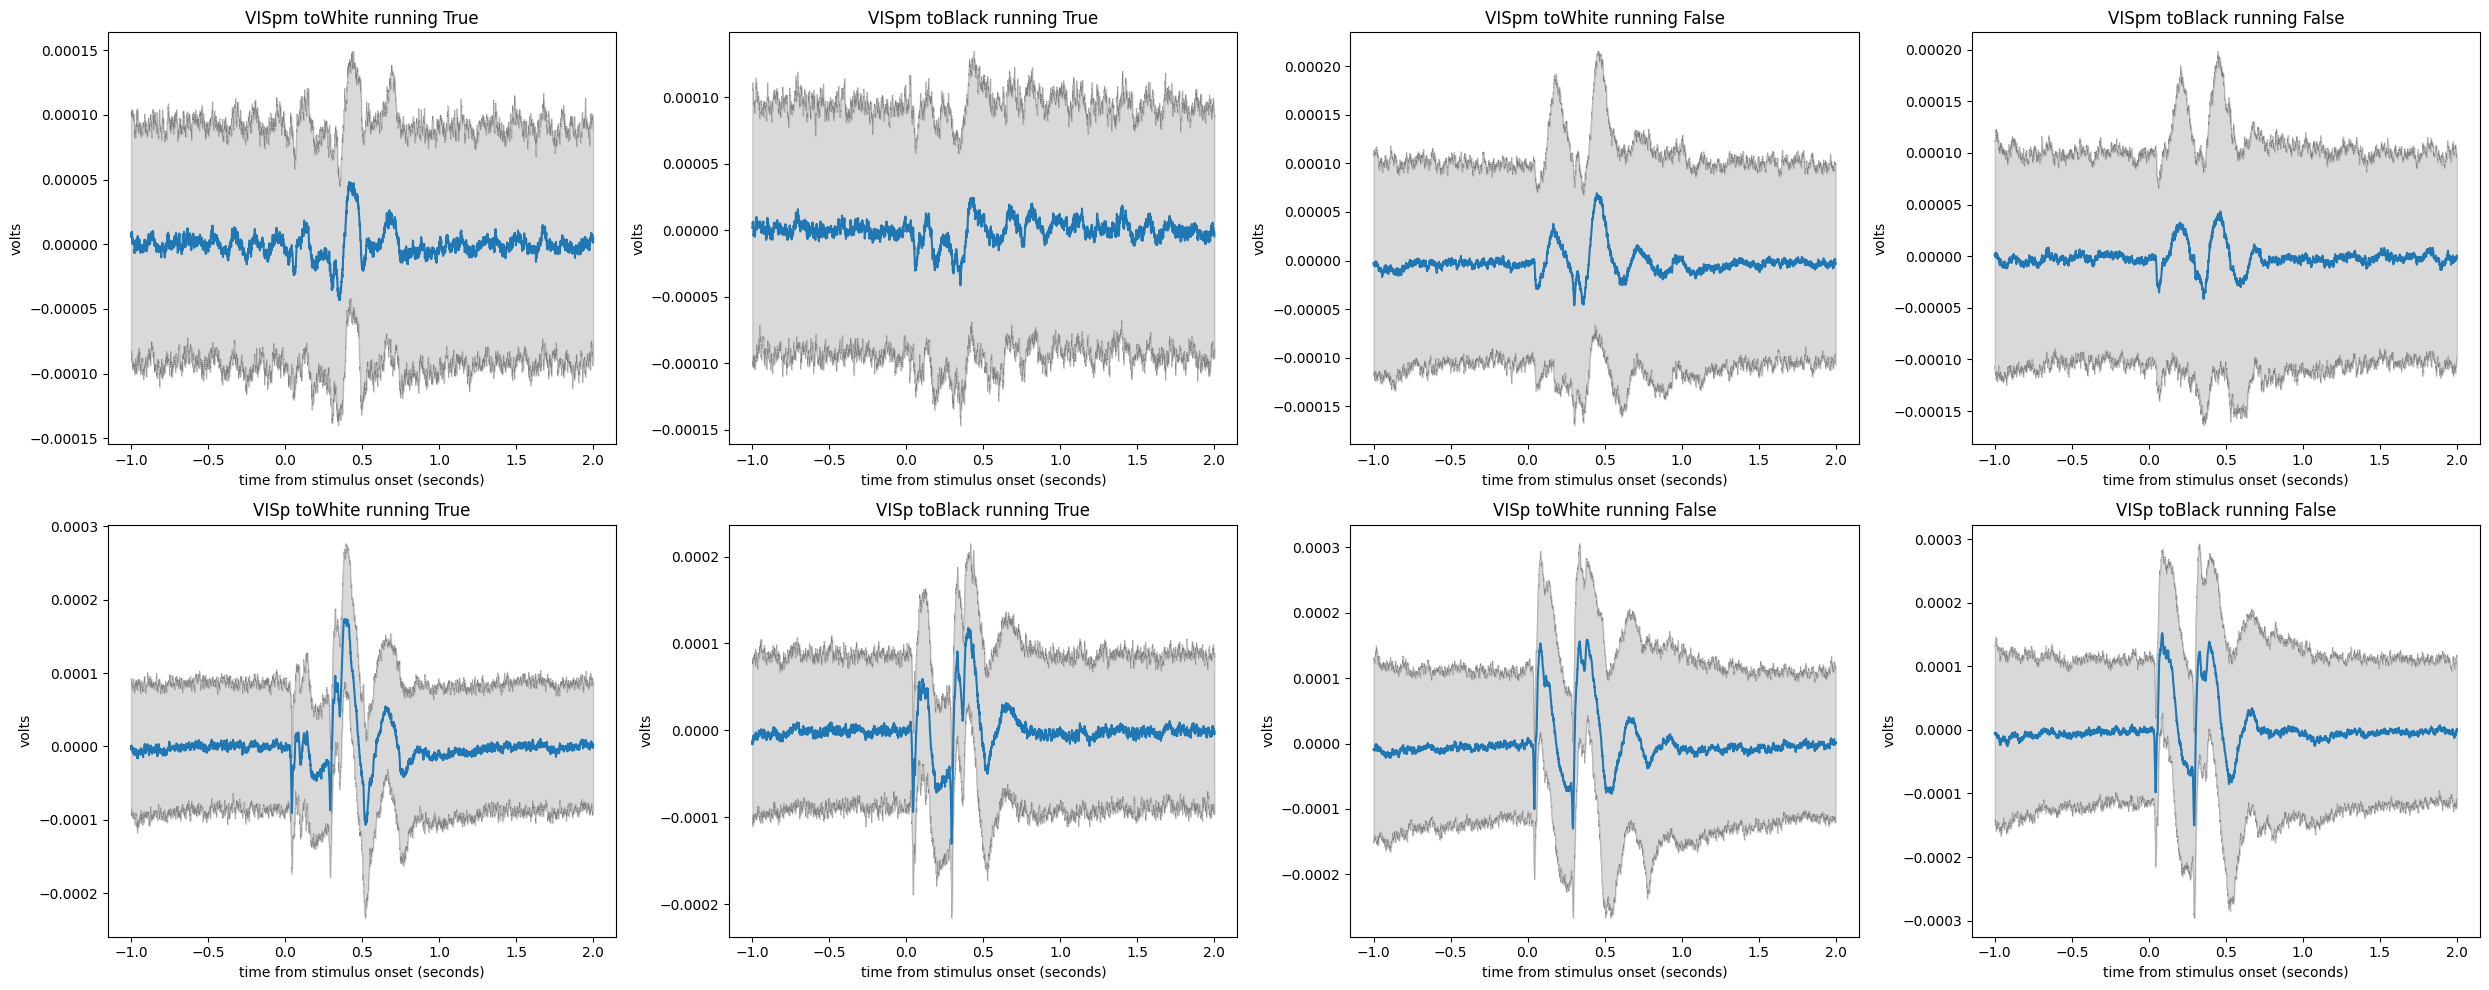

In [97]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(25,10))

for i in range(4):
    ax[0][i].plot(t,weighted_average_lfps[i][1])
    lower = weighted_average_lfps[i][1] - weighted_average_lfps[i][2]
    upper = weighted_average_lfps[i][1] + weighted_average_lfps[i][2]
    ax[0][i].plot(t,lower,linestyle='--',linewidth=0.3, color='gray')
    ax[0][i].plot(t,upper,linestyle='--',linewidth=0.3, color='gray')
    ax[0][i].fill_between(t,upper,lower, color='k', alpha=0.15)
    ax[0][i].set_title(f'{conditions[i][0]} {conditions[i][1]} running {conditions[i][2]}')
    ax[0][i].set_xlabel('time from stimulus onset (seconds)')
    ax[0][i].set_ylabel('volts')
    
for i in range(4):
    ax[1][i].plot(t,weighted_average_lfps[4+i][1])
    lower = weighted_average_lfps[4+i][1] - weighted_average_lfps[4+i][2]
    upper = weighted_average_lfps[4+i][1] + weighted_average_lfps[4+i][2]
    ax[1][i].plot(t,lower,linestyle='--',linewidth=0.3, color='gray')
    ax[1][i].plot(t,upper,linestyle='--',linewidth=0.3, color='gray')
    ax[1][i].fill_between(t,upper,lower, color='k', alpha=0.15)
    ax[1][i].set_title(f'{conditions[4+i][0]} {conditions[4+i][1]} running {conditions[4+i][2]}')
    ax[1][i].set_xlabel('time from stimulus onset (seconds)')
    ax[1][i].set_ylabel('volts')
    
plt.tight_layout()

plt.savefig('grand_average_lfp_traces.png')

plt.show()